Задача классификации изображений персонажей симпсонов https://www.kaggle.com/competitions/journey-springfield

In [1]:
import pandas as pd
import torch
import numpy as np
import PIL
from PIL import Image
import pickle
from skimage import io
from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки игнорируруем ошибки

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

в целях использования GPU мощностей google colab, заливаем архив с ихображениями на google диск

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

Mounted at /content/gdrive/


In [3]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Для удобстава определим свой класс датасета с картинками, который паралельно подгружает их из папок,
производит скалирование и превращение в торчевые тензоры


In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [11]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_test = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        # разные траснформации для разнообразия обучающей выборки
        transform_train = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAdjustSharpness(sharpness_factor=2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])        
        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        w, h = x.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp) #паддинг необходим, что бы при ресайзе изображение не искажалось, не теряло своих пропорций

        x = transforms.functional.pad(x, padding, 0, 'constant')  
        
        if self.mode == 'test':
            x = transform_test(x)
            return x
        else:
            x = transform_train(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):

        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [14]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

Проверим что картинки выгружаются

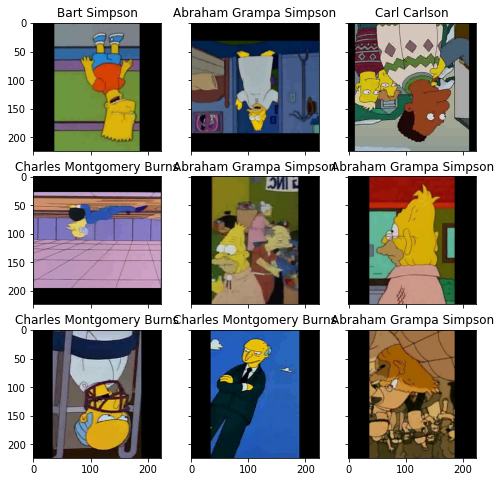

In [15]:

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Определим цикл обучения

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
        
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE) #отправляем данные на гпу
        labels = labels.to(DEVICE) #отправляем данные на гпу
        optimizer.zero_grad() №обнуляем градиент

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() #обновляем веса
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0) 
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data #считаем лос по эпохе
    train_acc = running_corrects.cpu().numpy() / processed_data #считаем точность по эпохе
    
    
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [44]:
def train(train_files, val_files, model, opt, epochs, batch_size):
    train_loader = DataLoader(train_dataset_oversmpl, batch_size=batch_size, shuffle=True) #train_dataset_oversmpl
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}" #вывод информации по эпохе в процессе обучения

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if train_acc > best_acc:
                best_acc = train_acc
                best_model_wts = model.state_dict() #сохраняем лучшие веса модели
                
    model.load_state_dict(best_model_wts) #загружаем лучшие веса модели
            
    return history, best_model_wts

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
n_classes = len(np.unique(train_val_labels))

Для решения задачи я решил взять предобученную vgg16 с батчнормом в виду простоты архитектуры.

In [21]:
model_vgg16_bn = models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Проведем небольшой тюнинг сети под нашу задачу

In [22]:
layers_to_unfreeze = 7 #буду обучать семь верхних слоев фичаэкстрактора

for param in model_vgg16_bn.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 4096
model_vgg16_bn.classifier[6] = nn.Linear(num_features, n_classes) #последний слой классификатора переделываю под кол-во классов в задаче

model_vgg16_bn = model_vgg16_bn.cuda()

In [24]:
optimizer_vgg = torch.optim.AdamW(list(model_vgg16_bn.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_vgg16_bn.classifier.parameters()), lr=1e-3, amsgrad=True) #зададим оптимайзер, укажем ему для каких параметров считать градиент

In [27]:
history_vgg, best_model_wts_vgg = train(train_dataset, val_dataset, model=model_vgg16_bn, opt=optimizer_vgg, epochs=10, batch_size=128) #путем проб и ошибок подобрал оптимальное кол-во эпох обучения и размер батча

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.9704072571718068


epoch:  10%|█         | 1/10 [04:35<41:19, 275.46s/it]


Epoch 001 train_loss: 1.9704     val_loss 1.0036 train_acc 0.4788 val_acc 0.7442
loss 0.7463639178043096


epoch:  20%|██        | 2/10 [09:00<35:53, 269.23s/it]


Epoch 002 train_loss: 0.7464     val_loss 0.7099 train_acc 0.7998 val_acc 0.8177
loss 0.47520123423000105


epoch:  30%|███       | 3/10 [13:20<30:54, 264.97s/it]


Epoch 003 train_loss: 0.4752     val_loss 0.5772 train_acc 0.8706 val_acc 0.8506
loss 0.3505958763913247


epoch:  40%|████      | 4/10 [17:42<26:23, 263.83s/it]


Epoch 004 train_loss: 0.3506     val_loss 0.5473 train_acc 0.9031 val_acc 0.8536
loss 0.2647971718681414


epoch:  50%|█████     | 5/10 [22:03<21:53, 262.72s/it]


Epoch 005 train_loss: 0.2648     val_loss 0.5467 train_acc 0.9293 val_acc 0.8645
loss 0.20499812472898554


epoch:  60%|██████    | 6/10 [26:24<17:28, 262.22s/it]


Epoch 006 train_loss: 0.2050     val_loss 0.5337 train_acc 0.9430 val_acc 0.8750
loss 0.16498089988878314


epoch:  70%|███████   | 7/10 [30:44<13:05, 261.71s/it]


Epoch 007 train_loss: 0.1650     val_loss 0.5183 train_acc 0.9573 val_acc 0.8808
loss 0.11847712017068499


epoch:  80%|████████  | 8/10 [35:04<08:41, 260.86s/it]


Epoch 008 train_loss: 0.1185     val_loss 0.5255 train_acc 0.9671 val_acc 0.8787
loss 0.10651717901954082


epoch:  90%|█████████ | 9/10 [39:23<04:20, 260.50s/it]


Epoch 009 train_loss: 0.1065     val_loss 0.5622 train_acc 0.9725 val_acc 0.8770
loss 0.09973622467652409


epoch: 100%|██████████| 10/10 [43:42<00:00, 262.28s/it]


Epoch 010 train_loss: 0.0997     val_loss 0.5565 train_acc 0.9725 val_acc 0.8840


In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [49]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters] #выбираю одну случайну картинку из валидационной выборки и ее класс
probs_im = predict_one_sample(model_vgg16_bn, ex_img.unsqueeze(0)) 
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs] #20 изображений из валидационной выборки

probs_ims = predict(model_vgg16_bn, imgs) #делаю предсказания
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [50]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
target_names = val_dataset.labels

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(model_vgg16_bn, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]



df = pd.DataFrame() #датафрейм для сабмита
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/MyDrive/simpsons_simple_cnn_baseline.csv', index=False)

In [51]:
from sklearn.metrics import f1_score #согласно условиям задачи модель стоит оценивать по f1_score
f1_score(actual_labels, y_pred, average='weighted')

1.0

Мы получили результаты, далее попробуем посмотреть на каких классах наша модель работает хуже всего, попытаемся понять почему

In [34]:
import itertools
from sklearn.metrics import confusion_matrix
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model):
    """Построить и посчитать точность классов по confusion matrix"""
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))
    

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    #cm = confusion_matrix(y_test_all, predictions_all, np.arange(n_classes))
    # Выведем её
    #plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all
  
def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(dataloaders['val'].dataset.labels))
    

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [35]:
BATCH_SIZE = 128
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

In [36]:
y_test_all, predictions_all = show_confusion_matrix_fucn(model_vgg16_bn)
accurancy_for_each_class(y_test_all, predictions_all)

[199, 10, 138, 14, 333, 29, 328, 220, 7, 122, 1, 108, 6, 0, 29, 634, 134, 297, 45, 2, 353, 18, 305, 22, 68, 289, 1, 388, 310, 119, 4, 8, 342, 14, 11, 19, 27, 223, 3, 19, 0, 35]
42
Accuracy of abraham_grampa_simpson : 95 %
Accuracy of agnes_skinner : 40 %
Accuracy of apu_nahasapeemapetilon : 98 %
Accuracy of barney_gumble : 85 %
Accuracy of bart_simpson : 94 %
Accuracy of carl_carlson : 79 %
Accuracy of charles_montgomery_burns : 84 %
Accuracy of chief_wiggum : 97 %
Accuracy of cletus_spuckler : 71 %
Accuracy of comic_book_guy : 84 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 91 %
Accuracy of fat_tony : 83 %
Accuracy of   gil : -1 %
Accuracy of groundskeeper_willie : 82 %
Accuracy of homer_simpson : 82 %
Accuracy of kent_brockman : 88 %
Accuracy of krusty_the_clown : 94 %
Accuracy of lenny_leonard : 97 %
Accuracy of lionel_hutz : 50 %
Accuracy of lisa_simpson : 91 %
Accuracy of maggie_simpson : 72 %
Accuracy of marge_simpson : 97 %
Accuracy of martin_prince : 40 %
Accura

Согласно полученных результатов в задаче есть классы точность определения которых сильно ниже остальных. Первая из возможных причин - десбалансировка классов в обучающей выборке. Далее я решил попробовать оверсэмплинг как один из путей балансировки классов таким образом чтоб у каждого класса было минимум 100 экземпляров

In [37]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [38]:
dct_path_train = create_dct_path_labels(train_files, train_labels) #Создадим словарь в котором ключами будут название класса, а значениями списки с путями к изображениям

In [39]:
"""Дополним классы имеющие менее 100 экземпляров"""
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [41]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

Теперь переобъявим тренировочный датасет и запустим обучение заново

In [42]:
train_dataset_oversmpl = SimpsonsDataset(new_train_files, mode='train')

In [45]:
history_vgg, best_model_wts_vgg = train(train_dataset_oversmpl, val_dataset, model=model_vgg16_bn, opt=optimizer_vgg, epochs=10, batch_size=128) 

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.04362481835547126


epoch:  10%|█         | 1/10 [04:37<41:40, 277.81s/it]


Epoch 001 train_loss: 0.0436     val_loss 0.6328 train_acc 0.9877 val_acc 0.8919
loss 0.051683845074439974


epoch:  20%|██        | 2/10 [09:15<36:59, 277.45s/it]


Epoch 002 train_loss: 0.0517     val_loss 0.7217 train_acc 0.9870 val_acc 0.8712
loss 0.03956050045411239


epoch:  30%|███       | 3/10 [13:53<32:24, 277.85s/it]


Epoch 003 train_loss: 0.0396     val_loss 0.5581 train_acc 0.9899 val_acc 0.8997
loss 0.02498908520845151


epoch:  40%|████      | 4/10 [18:30<27:44, 277.43s/it]


Epoch 004 train_loss: 0.0250     val_loss 0.6033 train_acc 0.9921 val_acc 0.8942
loss 0.030886538901960806


epoch:  50%|█████     | 5/10 [23:06<23:04, 276.94s/it]


Epoch 005 train_loss: 0.0309     val_loss 0.6921 train_acc 0.9922 val_acc 0.8848
loss 0.017185270806488403


epoch:  60%|██████    | 6/10 [27:42<18:26, 276.60s/it]


Epoch 006 train_loss: 0.0172     val_loss 0.6048 train_acc 0.9947 val_acc 0.8947
loss 0.029233432335591097


epoch:  70%|███████   | 7/10 [32:19<13:50, 276.74s/it]


Epoch 007 train_loss: 0.0292     val_loss 0.5636 train_acc 0.9913 val_acc 0.9026
loss 0.022032873590591744


epoch:  80%|████████  | 8/10 [36:56<09:13, 276.80s/it]


Epoch 008 train_loss: 0.0220     val_loss 0.6710 train_acc 0.9935 val_acc 0.8894
loss 0.023326168803332225


epoch:  90%|█████████ | 9/10 [41:29<04:35, 275.66s/it]


Epoch 009 train_loss: 0.0233     val_loss 0.6332 train_acc 0.9925 val_acc 0.8926
loss 0.03133911275100619


epoch: 100%|██████████| 10/10 [46:00<00:00, 276.03s/it]


Epoch 010 train_loss: 0.0313     val_loss 0.6024 train_acc 0.9918 val_acc 0.8942


Оверсэмплинг привел к незначительному улучшению качества модели